# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of industrial crop production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
grapes_olives = pd.read_csv('./Italy_crop_data/italy_grapes_olives_oil.csv',skipinitialspace=True)
grapes_olives.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC18,Alessandria,HP_Q_EXT,harvested production - quintals,WINEES,wine grapes,2020,2020,845189,NaN,NaN
1,ITC18,Alessandria,HP_Q_EXT,harvested production - quintals,WINEES,wine grapes,2021,2021,983600,NaN,NaN
2,ITC18,Alessandria,HP_Q_EXT,harvested production - quintals,WINEES,wine grapes,2022,2022,634304,NaN,NaN
3,ITF62,Crotone,HP_Q_EXT,harvested production - quintals,WINEES,wine grapes,2020,2020,132420,NaN,NaN
4,ITF62,Crotone,HP_Q_EXT,harvested production - quintals,WINEES,wine grapes,2021,2021,105880,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
grapes_olives = grapes_olives.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
grapes_olives

,Territory,Data type,Type of crop,Select time,Value
0,Alessandria,harvested production - quintals,wine grapes,2020,845189
1,Alessandria,harvested production - quintals,wine grapes,2021,983600
2,Alessandria,harvested production - quintals,wine grapes,2022,634304
3,Crotone,harvested production - quintals,wine grapes,2020,132420
4,Crotone,harvested production - quintals,wine grapes,2021,105880
...,...,...,...,...,...
10101,Valle d'Aosta / Vallée d'Aoste,production area - hectares,other olives,2021,1
10102,Valle d'Aosta / Vallée d'Aoste,total production - quintals,other olives,2021,40
10103,Valle d'Aosta / Vallée d'Aoste,harvested production - quintals,other olives,2021,40
10104,Milano,production area - hectares,other olives,2021,2


In [4]:
# Rename Columns
grapes_olives = grapes_olives.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
grapes_olives.Type_crop.unique()

array(['wine grapes', 'table and oil olives', 'oil olives',
       'Grapes for table use', 'olive oil', 'table olives', 'table winw',
       'wine', 'whithe wine', 'red and rosé wine',
       'registered designation of origin wine',
       'registered designation of origin white wine',
       'registered designation of origin black wine',
       'typical geographical indication wine',
       'typical geographical indication white wine',
       'typical geographical indication black wine',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)',
       'grapes for other purposes n.e.c.', 'grapes for raisins', 'must',
       'other olives'], dtype=object)

In [6]:
grapes_olives =grapes_olives.replace('table and oil olives', 'table olives')

In [7]:
grapes_olives =grapes_olives.replace('oil olives', 'olive oil')

In [8]:
grapes_olives 

,City,Data_type,Type_crop,Year,Value
0,Alessandria,harvested production - quintals,wine grapes,2020,845189
1,Alessandria,harvested production - quintals,wine grapes,2021,983600
2,Alessandria,harvested production - quintals,wine grapes,2022,634304
3,Crotone,harvested production - quintals,wine grapes,2020,132420
4,Crotone,harvested production - quintals,wine grapes,2021,105880
...,...,...,...,...,...
10101,Valle d'Aosta / Vallée d'Aoste,production area - hectares,other olives,2021,1
10102,Valle d'Aosta / Vallée d'Aoste,total production - quintals,other olives,2021,40
10103,Valle d'Aosta / Vallée d'Aoste,harvested production - quintals,other olives,2021,40
10104,Milano,production area - hectares,other olives,2021,2


In [9]:
grapes_olives.Type_crop.unique()

array(['wine grapes', 'table olives', 'olive oil', 'Grapes for table use',
       'table winw', 'wine', 'whithe wine', 'red and rosé wine',
       'registered designation of origin wine',
       'registered designation of origin white wine',
       'registered designation of origin black wine',
       'typical geographical indication wine',
       'typical geographical indication white wine',
       'typical geographical indication black wine',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)',
       'grapes for other purposes n.e.c.', 'grapes for raisins', 'must',
       'other olives'], dtype=object)

In [10]:
def show_info(grapes_olives):
    print('DATASET SHAPE: ', grapes_olives.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(grapes_olives.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(grapes_olives.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(grapes_olives.isnull().sum())
show_info(grapes_olives)

DATASET SHAPE:  (10106, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10106 entries, 0 to 10105
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       10106 non-null  object
 1   Data_type  10106 non-null  object
 2   Type_crop  10106 non-null  object
 3   Year       10106 non-null  int64 
 4   Value      10106 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 394.9+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          106
Data_type       5
Type_crop      21
Year            3
Value        4146
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing grapes and olives crop

In [11]:
#grapes_olives.City.unique()


## Select only values for total grapes and olives crop production - quintals


In [12]:
grapes_olives_prod = grapes_olives[grapes_olives['Data_type'] == 'total production - quintals ']
grapes_olives_prod.head()

,City,Data_type,Type_crop,Year,Value
6,Benevento,total production - quintals,wine grapes,2020,1017450
7,Benevento,total production - quintals,wine grapes,2021,1114000
8,Benevento,total production - quintals,wine grapes,2022,1114000
12,Vibo Valentia,total production - quintals,wine grapes,2020,12985
13,Vibo Valentia,total production - quintals,wine grapes,2021,12985


In [13]:
grapes_olives_prod = grapes_olives_prod.rename(columns = {'Value':'Total_production'})
grapes_olives_prod

,City,Data_type,Type_crop,Year,Total_production
6,Benevento,total production - quintals,wine grapes,2020,1017450
7,Benevento,total production - quintals,wine grapes,2021,1114000
8,Benevento,total production - quintals,wine grapes,2022,1114000
12,Vibo Valentia,total production - quintals,wine grapes,2020,12985
13,Vibo Valentia,total production - quintals,wine grapes,2021,12985
...,...,...,...,...,...
10086,Trentino Alto Adige / Südtirol,total production - quintals,grapes for wines with protected geographical i...,2020,164963
10087,Trentino Alto Adige / Südtirol,total production - quintals,grapes for wines with protected geographical i...,2021,153152
10094,Trentino Alto Adige / Südtirol,total production - quintals,grapes for other wines n.e.c. (without pdo/pgi),2020,18610
10095,Trentino Alto Adige / Südtirol,total production - quintals,grapes for other wines n.e.c. (without pdo/pgi),2021,17865


In [14]:
grapes_olives_prod = grapes_olives_prod.drop(columns =['Data_type'])
grapes_olives_prod

,City,Type_crop,Year,Total_production
6,Benevento,wine grapes,2020,1017450
7,Benevento,wine grapes,2021,1114000
8,Benevento,wine grapes,2022,1114000
12,Vibo Valentia,wine grapes,2020,12985
13,Vibo Valentia,wine grapes,2021,12985
...,...,...,...,...
10086,Trentino Alto Adige / Südtirol,grapes for wines with protected geographical i...,2020,164963
10087,Trentino Alto Adige / Südtirol,grapes for wines with protected geographical i...,2021,153152
10094,Trentino Alto Adige / Südtirol,grapes for other wines n.e.c. (without pdo/pgi),2020,18610
10095,Trentino Alto Adige / Südtirol,grapes for other wines n.e.c. (without pdo/pgi),2021,17865


## Total grapes and olives crop production in 2020-2022

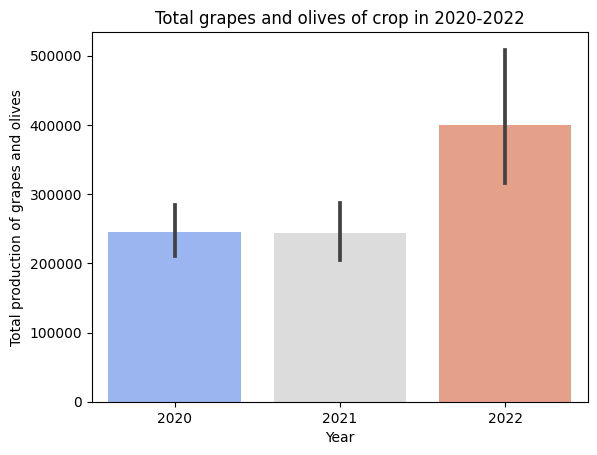

In [15]:

sns.barplot(x= 'Year', y= 'Total_production',data = grapes_olives_prod, palette='coolwarm')
plt.title('Total grapes and olives of crop in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total production of grapes and olives')
plt.show()



## Grapes and olives crop production by Cities 

In [16]:
grapes_olives_prod_region = grapes_olives_prod.groupby(by = grapes_olives_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
grapes_olives_prod_region



,City,Total_production
32,Foggia,44860760
94,Treviso,32314742
8,Barletta-Andria-Trani,25039000
22,Chieti,23620200
102,Verona,21672915
...,...,...
23,Como,10991
46,Lodi,7161
25,Cremona,6437
98,Varese,6249


In [17]:
region = grapes_olives_prod_region.nlargest(30, 'Total_production')

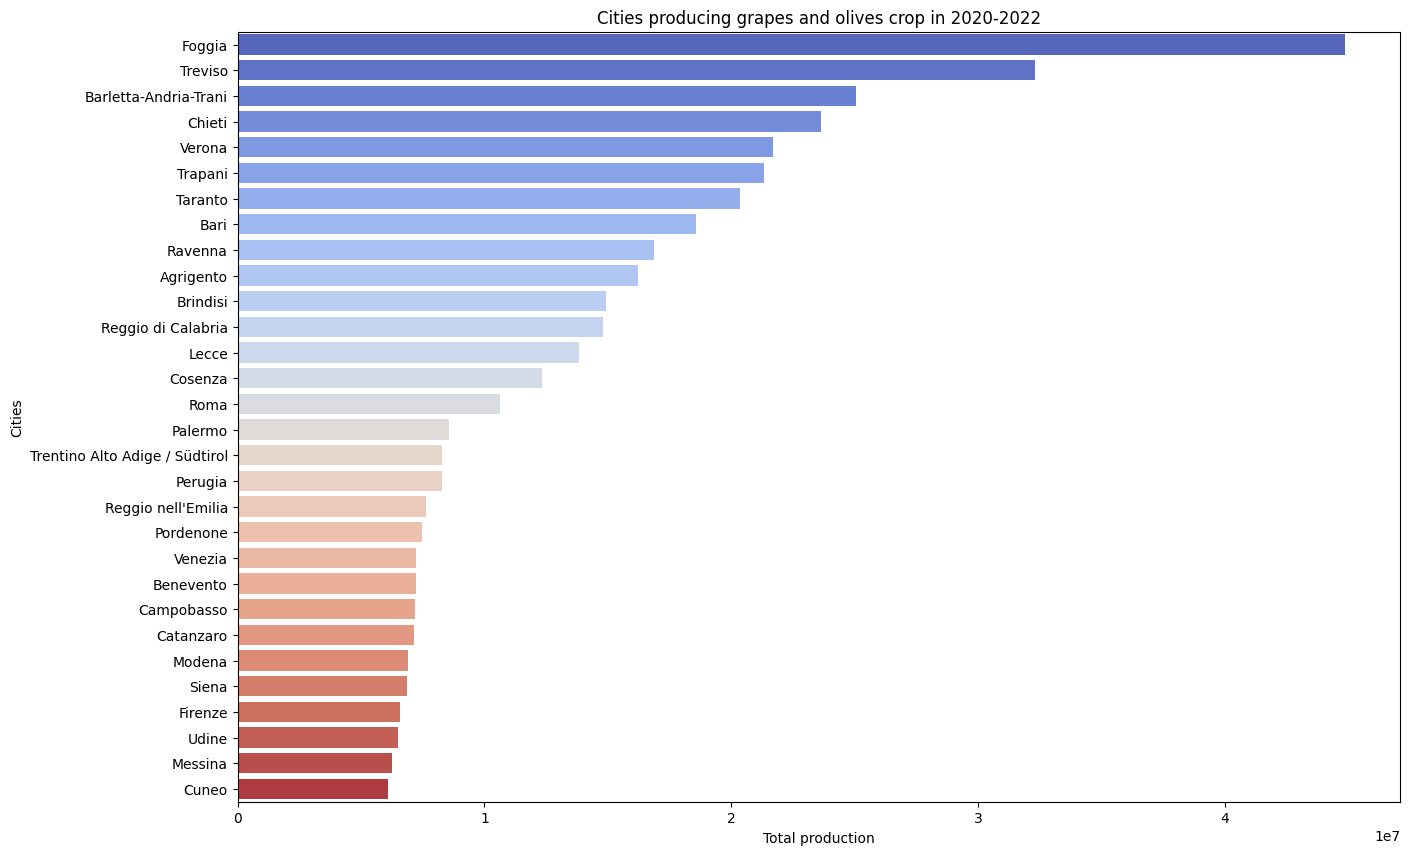

In [18]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Cities producing grapes and olives crop in 2020-2022')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show() 

##  Grapes and olives production  2020-2022

In [19]:
print(grapes_olives_prod.Type_crop.max())
print(grapes_olives_prod.Type_crop.value_counts())
print(grapes_olives_prod.Type_crop.nunique())



wine grapes
table olives                                                     412
olive oil                                                        394
wine grapes                                                      318
grapes for other wines n.e.c. (without pdo/pgi)                  212
Grapes for table use                                             205
other olives                                                     199
grapes for wines with protected designation of origin (pdo)      196
grapes for wines with protected geographical indication (pgi)    186
grapes for other purposes n.e.c.                                  12
grapes for raisins                                                 2
Name: Type_crop, dtype: int64
10


Dataset shows there are 10 different types of grapes and olives cultivated in Italy. The top most produced crops are :  Wine grapes, Table olives, Grapes for other wines, Grapes for table use ,Olive oil, Grapes for wines with protected designation of origin (pdo), Grapes for wines with protected geographical indication (pgi),Grapes for other wines n.e.c. (without pdo/pgi), Grapes for raisins, Grapes for other purposes n.e.c., Other olives,


<AxesSubplot: >

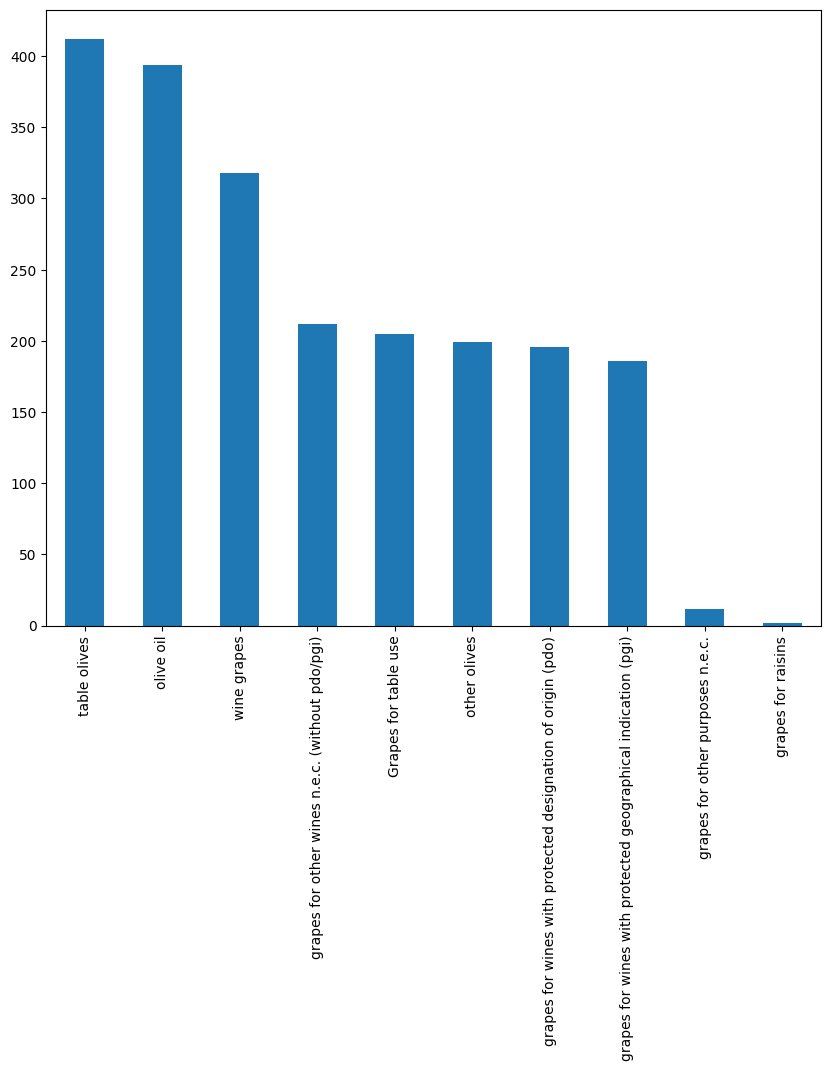

In [20]:
plt.figure(figsize=(10,8))
grapes_olives_prod ['Type_crop'].value_counts().plot.bar()

## Subseting data

## Stats

In [21]:
grapes_olives_prod.describe().astype(int)

,Year,Total_production
count,2136,2136
mean,2020,264320
std,0,652511
min,2020,1
25%,2020,3200
50%,2021,39550
75%,2021,218000
max,2022,8000000


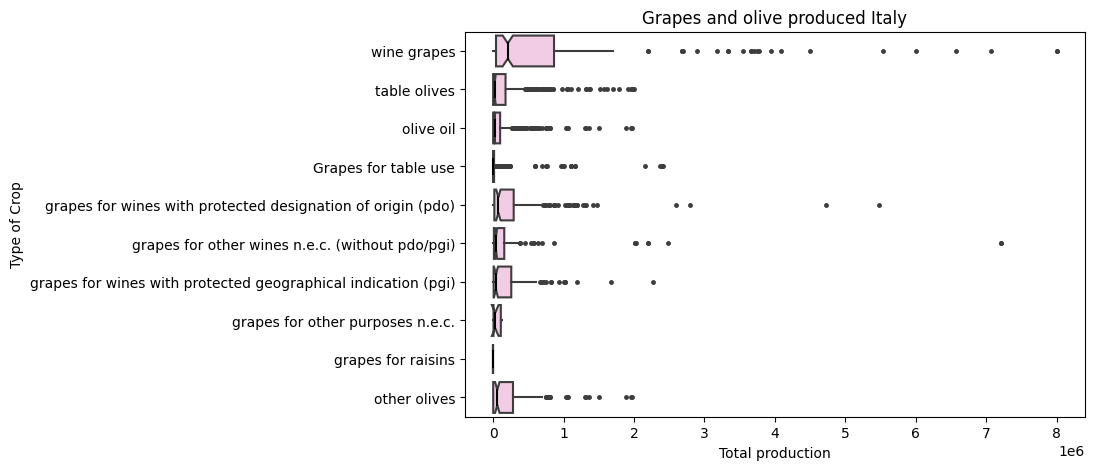

In [22]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=grapes_olives_prod, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Grapes and olive produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

## Vizualization of ten type of grapes and olives produced in Italy in the period of 2020-2022 

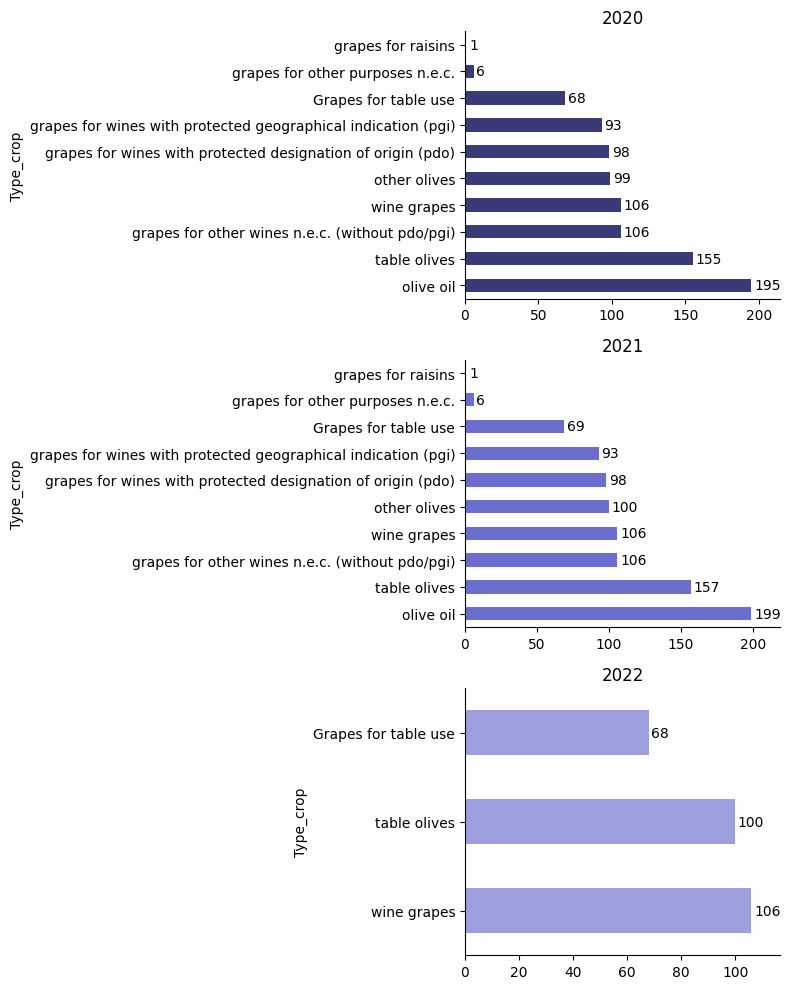

In [23]:
fig, axs = plt.subplots(3, figsize=(8, 10))

plot1 = grapes_olives_prod[grapes_olives_prod.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2020', ax=axs[0])
plot2 = grapes_olives_prod[grapes_olives_prod.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1])
plot3 = grapes_olives_prod[grapes_olives_prod.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#9c9ede', title='2022', ax=axs[2])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
sns.despine()
plt.tight_layout()
plt.show()

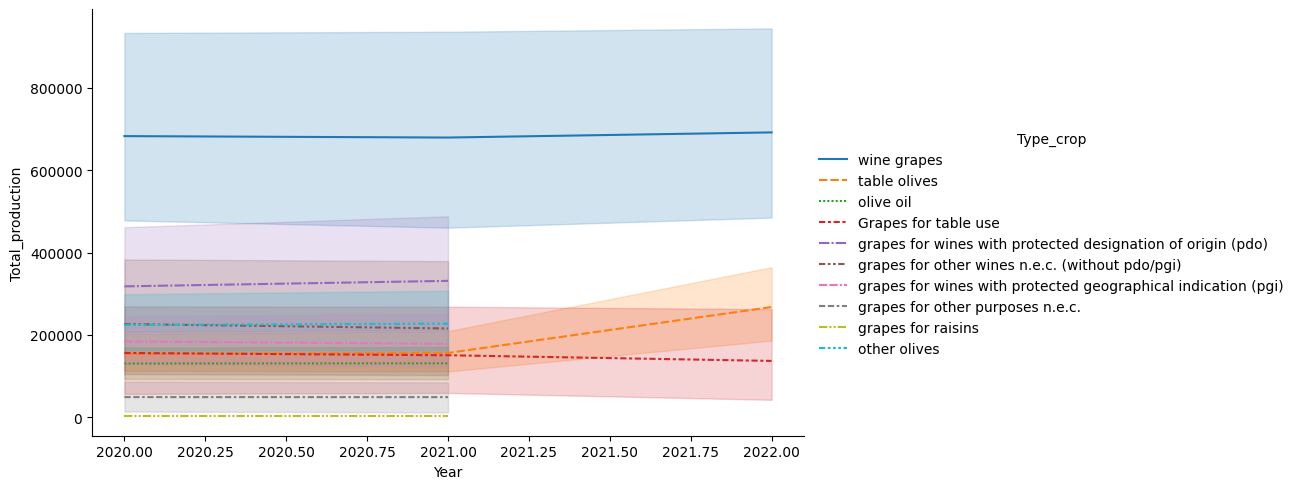

In [24]:
#Crop harvested by year
plotcrop = sns.relplot(kind='line', data=grapes_olives_prod, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [25]:
# Select year 2020 for future join with fertilizer
grapes_olives2020 = grapes_olives_prod[grapes_olives_prod['Year'] == 2020]
grapes_olives2020



,City,Type_crop,Year,Total_production
6,Benevento,wine grapes,2020,1017450
12,Vibo Valentia,wine grapes,2020,12985
18,Novara,wine grapes,2020,41650
30,Lecce,wine grapes,2020,643500
33,Vercelli,wine grapes,2020,15105
...,...,...,...,...
10062,Barletta-Andria-Trani,other olives,2020,1050000
10070,Sud Sardegna,other olives,2020,82202
10078,Trentino Alto Adige / Südtirol,grapes for wines with protected designation of...,2020,1480468
10086,Trentino Alto Adige / Südtirol,grapes for wines with protected geographical i...,2020,164963


In [26]:
grapes_olives2020.describe().astype(int)

,Year,Total_production
count,927,927
mean,2020,245058
std,0,610157
min,2020,1
25%,2020,4250
50%,2020,40269
75%,2020,210278
max,2020,8000000


In [27]:
# Select year 2020 for future join with fertilizer
grapes_olives2021 = grapes_olives_prod[grapes_olives_prod['Year'] == 2021]
grapes_olives2021

,City,Type_crop,Year,Total_production
7,Benevento,wine grapes,2021,1114000
13,Vibo Valentia,wine grapes,2021,12985
19,Novara,wine grapes,2021,41360
31,Lecce,wine grapes,2021,643375
34,Vercelli,wine grapes,2021,8462
...,...,...,...,...
10071,Sud Sardegna,other olives,2021,108310
10079,Trentino Alto Adige / Südtirol,grapes for wines with protected designation of...,2021,1417317
10087,Trentino Alto Adige / Südtirol,grapes for wines with protected geographical i...,2021,153152
10095,Trentino Alto Adige / Südtirol,grapes for other wines n.e.c. (without pdo/pgi),2021,17865


In [28]:
grapes_olives2021.describe().astype(int)

,Year,Total_production
count,935,935
mean,2021,243907
std,0,625507
min,2021,1
25%,2021,2716
50%,2021,35550
75%,2021,195351
max,2021,8000000


In [29]:
# Select year 2020 for future join with fertilizer
grapes_olives2022 = grapes_olives_prod[grapes_olives_prod['Year'] == 2022]
grapes_olives2022

,City,Type_crop,Year,Total_production
8,Benevento,wine grapes,2022,1114000
14,Vibo Valentia,wine grapes,2022,12985
20,Novara,wine grapes,2022,31920
32,Lecce,wine grapes,2022,750000
35,Vercelli,wine grapes,2022,9072
...,...,...,...,...
3671,Barletta-Andria-Trani,Grapes for table use,2022,1100000
3683,Sud Sardegna,Grapes for table use,2022,14146
3695,Fermo,table olives,2022,56100
3707,Barletta-Andria-Trani,table olives,2022,985000


In [30]:
grapes_olives2022.describe().astype(int)

,Year,Total_production
count,274,274
mean,2022,399147
std,0,841087
min,2022,2
25%,2022,2962
50%,2022,47561
75%,2022,413200
max,2022,7060958


In [31]:
grapes_olives2022.Type_crop.unique()

array(['wine grapes', 'table olives', 'Grapes for table use'],
      dtype=object)

### Create columns for each type crop 2020

In [32]:
# Create columns for each type crop
grapes_olives2020_pivot = grapes_olives2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
grapes_olives2020_pivot

Total_production                                   \
Type_crop          Grapes for table use grapes for other purposes n.e.c.   
City          Year                                                         
Agrigento     2020             985000.0                         120000.0   
Alessandria   2020                950.0                              NaN   
Ancona        2020                  NaN                              NaN   
Arezzo        2020               1440.0                              NaN   
Ascoli Piceno 2020               1041.0                              NaN   
...                                 ...                              ...   
Vercelli      2020                990.0                              NaN   
Verona        2020               4500.0                              NaN   
Vibo Valentia 2020               3770.0                              NaN   
Vicenza       2020               3100.0                              NaN   
Viterbo       2020               1100.0                              NaN   

                                                                    \
Type_crop          grapes for other wines n.e.c. (without pdo/pgi)   
City          Year                                                   
Agrigento     2020                                        214500.0   
Alessandria   2020                                         41749.0   
Ancona        2020                                        130423.0   
Arezzo        2020                                         35040.0   
Ascoli Piceno 2020                                        287248.0   
...                                                            ...   
Vercelli      2020                                          3330.0   
Verona        2020                                        871093.0   
Vibo Valentia 2020                                         12446.0   
Vicenza       2020                                        128651.0   
Viterbo       2020                                         26500.0   

                                       \
Type_crop          grapes for raisins   
City          Year                      
Agrigento     2020                NaN   
Alessandria   2020                NaN   
Ancona        2020                NaN   
Arezzo        2020                NaN   
Ascoli Piceno 2020                NaN   
...                               ...   
Vercelli      2020                NaN   
Verona        2020                NaN   
Vibo Valentia 2020                NaN   
Vicenza       2020                NaN   
Viterbo       2020                NaN   

                                                                                \
Type_crop          grapes for wines with protected designation of origin (pdo)   
City          Year                                                               
Agrigento     2020                                          1300000.0            
Alessandria   2020                                           803440.0            
Ancona        2020                                           260321.0            
Arezzo        2020                                           211420.0            
Ascoli Piceno 2020                                           131785.0            
...                                                               ...            
Vercelli      2020                                            11775.0            
Verona        2020                                          2600705.0            
Vibo Valentia 2020                                                NaN            
Vicenza       2020                                           624698.0            
Viterbo       2020                                            75000.0            

                                                                                  \
Type_crop          grapes for wines with protected geographical indication (pgi)   
City          Year                                                                 
A

In [33]:
# Drop level
grapes_olives2020_pivot.columns = grapes_olives2020_pivot.columns.droplevel()
grapes_olives2020_pivot

,Type_crop,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
City,Year,,,,,,,,,,
Agrigento,2020,985000.0,120000.0,214500.0,NaN,1300000.0,685000.0,354500.0,308000.0,423060.0,2199500.0
Alessandria,2020,950.0,NaN,41749.0,NaN,803440.0,NaN,176.0,160.0,224.0,845189.0
Ancona,2020,NaN,NaN,130423.0,NaN,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
Arezzo,2020,1440.0,NaN,35040.0,NaN,211420.0,92800.0,202300.0,178500.0,178500.0,339260.0
Ascoli Piceno,2020,1041.0,NaN,287248.0,NaN,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,990.0,NaN,3330.0,NaN,11775.0,NaN,12.0,12.0,12.0,15105.0
Verona,2020,4500.0,NaN,871093.0,NaN,2600705.0,1025273.0,203562.0,182190.0,182606.0,4497071.0
Vibo Valentia,2020,3770.0,NaN,12446.0,NaN,NaN,539.0,861065.0,764730.0,765690.0,12985.0


In [34]:
grapes_olives2020_pivot = grapes_olives2020_pivot.fillna(0)
grapes_olives2020_pivot

,Type_crop,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
City,Year,,,,,,,,,,
Agrigento,2020,985000.0,120000.0,214500.0,0.0,1300000.0,685000.0,354500.0,308000.0,423060.0,2199500.0
Alessandria,2020,950.0,0.0,41749.0,0.0,803440.0,0.0,176.0,160.0,224.0,845189.0
Ancona,2020,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
Arezzo,2020,1440.0,0.0,35040.0,0.0,211420.0,92800.0,202300.0,178500.0,178500.0,339260.0
Ascoli Piceno,2020,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,990.0,0.0,3330.0,0.0,11775.0,0.0,12.0,12.0,12.0,15105.0
Verona,2020,4500.0,0.0,871093.0,0.0,2600705.0,1025273.0,203562.0,182190.0,182606.0,4497071.0
Vibo Valentia,2020,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0


In [35]:
#Rename index
grapes_olives2020_pivot = grapes_olives2020_pivot.rename_axis(None,axis=1)
grapes_olives2020_pivot

,,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
City,Year,,,,,,,,,,
Agrigento,2020,985000.0,120000.0,214500.0,0.0,1300000.0,685000.0,354500.0,308000.0,423060.0,2199500.0
Alessandria,2020,950.0,0.0,41749.0,0.0,803440.0,0.0,176.0,160.0,224.0,845189.0
Ancona,2020,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
Arezzo,2020,1440.0,0.0,35040.0,0.0,211420.0,92800.0,202300.0,178500.0,178500.0,339260.0
Ascoli Piceno,2020,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,990.0,0.0,3330.0,0.0,11775.0,0.0,12.0,12.0,12.0,15105.0
Verona,2020,4500.0,0.0,871093.0,0.0,2600705.0,1025273.0,203562.0,182190.0,182606.0,4497071.0
Vibo Valentia,2020,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0


In [36]:
# Reset index
grapes_olives2020_pivot = grapes_olives2020_pivot.reset_index()
grapes_olives2020_pivot

,City,Year,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
0,Agrigento,2020,985000.0,120000.0,214500.0,0.0,1300000.0,685000.0,354500.0,308000.0,423060.0,2199500.0
1,Alessandria,2020,950.0,0.0,41749.0,0.0,803440.0,0.0,176.0,160.0,224.0,845189.0
2,Ancona,2020,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
3,Arezzo,2020,1440.0,0.0,35040.0,0.0,211420.0,92800.0,202300.0,178500.0,178500.0,339260.0
4,Ascoli Piceno,2020,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vercelli,2020,990.0,0.0,3330.0,0.0,11775.0,0.0,12.0,12.0,12.0,15105.0
102,Verona,2020,4500.0,0.0,871093.0,0.0,2600705.0,1025273.0,203562.0,182190.0,182606.0,4497071.0
103,Vibo Valentia,2020,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0
104,Vicenza,2020,3100.0,0.0,128651.0,0.0,624698.0,412571.0,32164.0,29174.0,29384.0,1165920.0


### Create columns for each type crop 2021

In [37]:
# Create columns for each type crop
grapes_olives2021_pivot = grapes_olives2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
grapes_olives2021_pivot

Total_production                                   \
Type_crop          Grapes for table use grapes for other purposes n.e.c.   
City          Year                                                         
Agrigento     2021             968704.0                         117600.0   
Alessandria   2021               1316.0                              NaN   
Ancona        2021                  NaN                              NaN   
Arezzo        2021               1320.0                              NaN   
Ascoli Piceno 2021               1041.0                              NaN   
...                                 ...                              ...   
Vercelli      2021               8688.0                              NaN   
Verona        2021               5250.0                              NaN   
Vibo Valentia 2021               3770.0                              NaN   
Vicenza       2021               2250.0                              NaN   
Viterbo       2021               1010.0                              NaN   

                                                                    \
Type_crop          grapes for other wines n.e.c. (without pdo/pgi)   
City          Year                                                   
Agrigento     2021                                        217070.0   
Alessandria   2021                                         69300.0   
Ancona        2021                                        130423.0   
Arezzo        2021                                          6069.0   
Ascoli Piceno 2021                                        287248.0   
...                                                            ...   
Vercelli      2021                                          1062.0   
Verona        2021                                        328375.0   
Vibo Valentia 2021                                         12446.0   
Vicenza       2021                                         30321.0   
Viterbo       2021                                         27980.0   

                                       \
Type_crop          grapes for raisins   
City          Year                      
Agrigento     2021                NaN   
Alessandria   2021                NaN   
Ancona        2021                NaN   
Arezzo        2021                NaN   
Ascoli Piceno 2021                NaN   
...                               ...   
Vercelli      2021                NaN   
Verona        2021                NaN   
Vibo Valentia 2021                NaN   
Vicenza       2021                NaN   
Viterbo       2021                NaN   

                                                                                \
Type_crop          grapes for wines with protected designation of origin (pdo)   
City          Year                                                               
Agrigento     2021                                          1321980.0            
Alessandria   2021                                           914376.0            
Ancona        2021                                           260321.0            
Arezzo        2021                                           148686.0            
Ascoli Piceno 2021                                           131785.0            
...                                                               ...            
Vercelli      2021                                             7400.0            
Verona        2021                                          2800148.0            
Vibo Valentia 2021                                                NaN            
Vicenza       2021                                           683218.0            
Viterbo       2021                                            78800.0            

                                                                                  \
Type_crop          grapes for wines with protected geographical indication (pgi)   
City          Year                                                                 
A

In [38]:
# Drop level
grapes_olives2021_pivot.columns = grapes_olives2021_pivot.columns.droplevel()
grapes_olives2021_pivot

,Type_crop,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
City,Year,,,,,,,,,,
Agrigento,2021,968704.0,117600.0,217070.0,NaN,1321980.0,661710.0,353321.0,305939.0,420339.0,2200760.0
Alessandria,2021,1316.0,NaN,69300.0,NaN,914376.0,NaN,308.0,280.0,344.0,983676.0
Ancona,2021,NaN,NaN,130423.0,NaN,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
Arezzo,2021,1320.0,NaN,6069.0,NaN,148686.0,77779.0,74340.0,63000.0,63000.0,232534.0
Ascoli Piceno,2021,1041.0,NaN,287248.0,NaN,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2021,8688.0,NaN,1062.0,NaN,7400.0,NaN,11.0,10.0,10.0,8462.0
Verona,2021,5250.0,NaN,328375.0,NaN,2800148.0,816675.0,20550.0,18220.0,18250.0,3945198.0
Vibo Valentia,2021,3770.0,NaN,12446.0,NaN,NaN,539.0,861065.0,764730.0,765690.0,12985.0


In [39]:
grapes_olives2021_pivot = grapes_olives2021_pivot.fillna(0)
grapes_olives2021_pivot

,Type_crop,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
City,Year,,,,,,,,,,
Agrigento,2021,968704.0,117600.0,217070.0,0.0,1321980.0,661710.0,353321.0,305939.0,420339.0,2200760.0
Alessandria,2021,1316.0,0.0,69300.0,0.0,914376.0,0.0,308.0,280.0,344.0,983676.0
Ancona,2021,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
Arezzo,2021,1320.0,0.0,6069.0,0.0,148686.0,77779.0,74340.0,63000.0,63000.0,232534.0
Ascoli Piceno,2021,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2021,8688.0,0.0,1062.0,0.0,7400.0,0.0,11.0,10.0,10.0,8462.0
Verona,2021,5250.0,0.0,328375.0,0.0,2800148.0,816675.0,20550.0,18220.0,18250.0,3945198.0
Vibo Valentia,2021,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0


In [40]:
#Rename index
grapes_olives2021_pivot = grapes_olives2021_pivot.rename_axis(None,axis=1)
grapes_olives2021_pivot

,,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
City,Year,,,,,,,,,,
Agrigento,2021,968704.0,117600.0,217070.0,0.0,1321980.0,661710.0,353321.0,305939.0,420339.0,2200760.0
Alessandria,2021,1316.0,0.0,69300.0,0.0,914376.0,0.0,308.0,280.0,344.0,983676.0
Ancona,2021,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
Arezzo,2021,1320.0,0.0,6069.0,0.0,148686.0,77779.0,74340.0,63000.0,63000.0,232534.0
Ascoli Piceno,2021,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2021,8688.0,0.0,1062.0,0.0,7400.0,0.0,11.0,10.0,10.0,8462.0
Verona,2021,5250.0,0.0,328375.0,0.0,2800148.0,816675.0,20550.0,18220.0,18250.0,3945198.0
Vibo Valentia,2021,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0


In [41]:
# Reset index
grapes_olives2021_pivot = grapes_olives2021_pivot.reset_index()
grapes_olives2021_pivot

,City,Year,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes
0,Agrigento,2021,968704.0,117600.0,217070.0,0.0,1321980.0,661710.0,353321.0,305939.0,420339.0,2200760.0
1,Alessandria,2021,1316.0,0.0,69300.0,0.0,914376.0,0.0,308.0,280.0,344.0,983676.0
2,Ancona,2021,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0
3,Arezzo,2021,1320.0,0.0,6069.0,0.0,148686.0,77779.0,74340.0,63000.0,63000.0,232534.0
4,Ascoli Piceno,2021,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0
...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vercelli,2021,8688.0,0.0,1062.0,0.0,7400.0,0.0,11.0,10.0,10.0,8462.0
102,Verona,2021,5250.0,0.0,328375.0,0.0,2800148.0,816675.0,20550.0,18220.0,18250.0,3945198.0
103,Vibo Valentia,2021,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0
104,Vicenza,2021,2250.0,0.0,30321.0,0.0,683218.0,264409.0,3305.0,2930.0,2950.0,977948.0


### Pre-process fertilizers dataset 

In [42]:
fertilizer = pd.read_csv('italy_fertilizers.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2019,2019,11,NaN,NaN
1,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2020,2020,11,NaN,NaN
2,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2021,2021,3,NaN,NaN
3,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2019,2019,8,NaN,NaN
4,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2020,2020,105,NaN,NaN


In [43]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [44]:
#fertilizer.Territory.unique()

In [45]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [46]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,containing micronutrients,2019,11
1,Rimini,containing micronutrients,2020,11
2,Rimini,containing micronutrients,2021,3
3,Trieste,peaty soil amendment,2019,8
4,Trieste,peaty soil amendment,2020,105
...,...,...,...,...
17670,Sud Sardegna,specific action products -,2020,422
17671,Sud Sardegna,specific action products -,2021,543
17672,Sud Sardegna,specific action products -,2019,164
17673,Sud Sardegna,specific action products -,2020,135


In [47]:
# Select year 2020 for future join with fertilizer
fertilizer2020 = fertilizer[fertilizer['Year'] == 2020]
fertilizer2020

,City,Type_fertilizer,Year,Fertilizers_tonnes
1,Rimini,containing micronutrients,2020,11
4,Trieste,peaty soil amendment,2020,105
7,Pisa,specific action products,2020,27
10,Pordenone,three components - nitrogen-phosphorous-phosph...,2020,8547
13,Venezia,soil correctives - sulphur for agricultural use,2020,5
...,...,...,...,...
17661,Sud Sardegna,soil correctives - other soil correctives,2020,2
17664,Sud Sardegna,crop substrates,2020,112
17667,Sud Sardegna,specific action products,2020,557
17670,Sud Sardegna,specific action products -,2020,422


In [48]:
#fertilizer2020.Type_fertilizer.unique()

In [49]:
#print(fertilizer2020.Type_fertilizer.max())
#print(fertilizer2020.Type_fertilizer.value_counts())
#print(fertilizer2020.Type_fertilizer.nunique())

In [50]:
fertilizer2020 = fertilizer2020.apply(lambda row: row[fertilizer2020['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2020.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
76,Pavia,ammonium sulphate,2020,747
154,Benevento,calcium cyanamide,2020,0
166,Treviso,ammonium sulphate,2020,1423
172,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2020,31
235,Alessandria,organic fertilizers,2020,2251


In [51]:
# Create columns for each type of fertilizer 
fertilizer2020_pivot = fertilizer2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2020_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2020                155                12                 1715   
Alessandria   2020                135               105                20968   
Ancona        2020                567                17                22511   
Arezzo        2020                 68                26                 3675   
Ascoli Piceno 2020                  8               158                 1065   
...                               ...               ...                  ...   
Vercelli      2020                 14              2570                 7604   
Verona        2020               3919               258                66460   
Vibo Valentia 2020               1433                 0                 2487   
Vicenza       2020               1350               225                10182   
Viterbo       2020                176                 0                14138   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2020                4006                    142   
Alessandria   2020                2251                    782   
Ancona        2020                2695                   1258   
Arezzo        2020                2053                     72   
Ascoli Piceno 2020                1284                     22   
...                                ...                    ...   
Vercelli      2020                6585                      0   
Verona        2020                9529                   9363   
Vibo Valentia 2020                  92                    157   
Vicenza       2020                1252                    220   
Viterbo       2020                2673                    603   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2020                    16  
Alessandria   2020                   743  
Ancona        2020                    33  
Arezzo        2020                   209  
Ascoli Piceno 2020                   267  
...                                  ...  
Vercelli      2020                  1013  
Verona        2020                  6141  
Vibo Valentia 2020                     0  
Vicenza       2020                   351  
Viterbo       2020                    10  

[108 rows x 6 columns]

In [52]:
# Drop level
fertilizer2020_pivot.columns = fertilizer2020_pivot.columns.droplevel()
fertilizer2020_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [53]:
#Rename index
fertilizer2020_pivot = fertilizer2020_pivot.rename_axis(None,axis=1)
fertilizer2020_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [54]:
# Reset index
fertilizer2020_pivot = fertilizer2020_pivot.reset_index()
fertilizer2020_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,155,12,1715,4006,142,16
1,Alessandria,2020,135,105,20968,2251,782,743
2,Ancona,2020,567,17,22511,2695,1258,33
3,Arezzo,2020,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...
103,Vercelli,2020,14,2570,7604,6585,0,1013
104,Verona,2020,3919,258,66460,9529,9363,6141
105,Vibo Valentia,2020,1433,0,2487,92,157,0
106,Vicenza,2020,1350,225,10182,1252,220,351


In [55]:
# Join both datasets 
it_crop_ferlizer = pd.merge(grapes_olives2020_pivot, fertilizer2020_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer


,City,Year,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,985000.0,120000.0,214500.0,0.0,1300000.0,685000.0,354500.0,308000.0,423060.0,2199500.0,155,12,1715,4006,142,16
1,Alessandria,2020,950.0,0.0,41749.0,0.0,803440.0,0.0,176.0,160.0,224.0,845189.0,135,105,20968,2251,782,743
2,Ancona,2020,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0,567,17,22511,2695,1258,33
3,Arezzo,2020,1440.0,0.0,35040.0,0.0,211420.0,92800.0,202300.0,178500.0,178500.0,339260.0,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vercelli,2020,990.0,0.0,3330.0,0.0,11775.0,0.0,12.0,12.0,12.0,15105.0,14,2570,7604,6585,0,1013
102,Verona,2020,4500.0,0.0,871093.0,0.0,2600705.0,1025273.0,203562.0,182190.0,182606.0,4497071.0,3919,258,66460,9529,9363,6141
103,Vibo Valentia,2020,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0,1433,0,2487,92,157,0
104,Vicenza,2020,3100.0,0.0,128651.0,0.0,624698.0,412571.0,32164.0,29174.0,29384.0,1165920.0,1350,225,10182,1252,220,351


## Analysis fertilizers 2021

In [56]:
# Select year 2020 for future join with fertilizer
fertilizer2021 = fertilizer[fertilizer['Year'] == 2021]
fertilizer2021

,City,Type_fertilizer,Year,Fertilizers_tonnes
2,Rimini,containing micronutrients,2021,3
5,Trieste,peaty soil amendment,2021,0
8,Pisa,specific action products,2021,33
11,Pordenone,three components - nitrogen-phosphorous-phosph...,2021,8286
14,Venezia,soil correctives - sulphur for agricultural use,2021,95
...,...,...,...,...
17662,Sud Sardegna,soil correctives - other soil correctives,2021,4
17665,Sud Sardegna,crop substrates,2021,40
17668,Sud Sardegna,specific action products,2021,736
17671,Sud Sardegna,specific action products -,2021,543


In [57]:
fertilizer2021 = fertilizer2021.apply(lambda row: row[fertilizer2021['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2021.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
77,Pavia,ammonium sulphate,2021,2504
155,Benevento,calcium cyanamide,2021,0
167,Treviso,ammonium sulphate,2021,1541
173,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2021,28
236,Alessandria,organic fertilizers,2021,3930


In [58]:
# Create columns for each type of fertilizer 
fertilizer2021_pivot = fertilizer2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2021_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2021                738                12                 4592   
Alessandria   2021                151               105                21951   
Ancona        2021                954                17                14630   
Arezzo        2021                 32                27                 2414   
Ascoli Piceno 2021                  3               158                 1610   
...                               ...               ...                  ...   
Vercelli      2021                  5              2571                 8929   
Verona        2021               7632               258                59389   
Vibo Valentia 2021                518                 0                 1498   
Vicenza       2021               1784               226                 6690   
Viterbo       2021                152                 0                11245   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2021                3668                   1075   
Alessandria   2021                3930                    900   
Ancona        2021                2500                   1809   
Arezzo        2021                2174                     71   
Ascoli Piceno 2021                1211                      8   
...                                ...                    ...   
Vercelli      2021                8312                    225   
Verona        2021               10023                  12968   
Vibo Valentia 2021                  61                    185   
Vicenza       2021                1634                   1100   
Viterbo       2021                2199                    587   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2021                    36  
Alessandria   2021                   713  
Ancona        2021                    43  
Arezzo        2021                     8  
Ascoli Piceno 2021                    46  
...                                  ...  
Vercelli      2021                  1014  
Verona        2021                 10878  
Vibo Valentia 2021                     0  
Vicenza       2021                   382  
Viterbo       2021                    11  

[108 rows x 6 columns]

In [59]:
# Drop level
fertilizer2021_pivot.columns = fertilizer2021_pivot.columns.droplevel()
fertilizer2021_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [60]:
#Rename index
fertilizer2021_pivot = fertilizer2021_pivot.rename_axis(None,axis=1)
fertilizer2021_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [61]:
# Reset index
fertilizer2021_pivot = fertilizer2021_pivot.reset_index()
fertilizer2021_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,738,12,4592,3668,1075,36
1,Alessandria,2021,151,105,21951,3930,900,713
2,Ancona,2021,954,17,14630,2500,1809,43
3,Arezzo,2021,32,27,2414,2174,71,8
4,Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...,...
103,Vercelli,2021,5,2571,8929,8312,225,1014
104,Verona,2021,7632,258,59389,10023,12968,10878
105,Vibo Valentia,2021,518,0,1498,61,185,0
106,Vicenza,2021,1784,226,6690,1634,1100,382


In [62]:
# Join both datasets 
it_crop_ferlizer2021 = pd.merge(grapes_olives2021_pivot, fertilizer2021_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer2021


,City,Year,Grapes for table use,grapes for other purposes n.e.c.,grapes for other wines n.e.c. (without pdo/pgi),grapes for raisins,grapes for wines with protected designation of origin (pdo),grapes for wines with protected geographical indication (pgi),olive oil,other olives,table olives,wine grapes,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,968704.0,117600.0,217070.0,0.0,1321980.0,661710.0,353321.0,305939.0,420339.0,2200760.0,738,12,4592,3668,1075,36
1,Alessandria,2021,1316.0,0.0,69300.0,0.0,914376.0,0.0,308.0,280.0,344.0,983676.0,151,105,21951,3930,900,713
2,Ancona,2021,0.0,0.0,130423.0,0.0,260321.0,27201.0,44088.0,39550.0,40988.0,417945.0,954,17,14630,2500,1809,43
3,Arezzo,2021,1320.0,0.0,6069.0,0.0,148686.0,77779.0,74340.0,63000.0,63000.0,232534.0,32,27,2414,2174,71,8
4,Ascoli Piceno,2021,1041.0,0.0,287248.0,0.0,131785.0,164392.0,94794.0,85852.0,98452.0,583425.0,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vercelli,2021,8688.0,0.0,1062.0,0.0,7400.0,0.0,11.0,10.0,10.0,8462.0,5,2571,8929,8312,225,1014
102,Verona,2021,5250.0,0.0,328375.0,0.0,2800148.0,816675.0,20550.0,18220.0,18250.0,3945198.0,7632,258,59389,10023,12968,10878
103,Vibo Valentia,2021,3770.0,0.0,12446.0,0.0,0.0,539.0,861065.0,764730.0,765690.0,12985.0,518,0,1498,61,185,0
104,Vicenza,2021,2250.0,0.0,30321.0,0.0,683218.0,264409.0,3305.0,2930.0,2950.0,977948.0,1784,226,6690,1634,1100,382


### Correlation 2020



In [63]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['City','wine grapes', 'table olives','olive oil',
                                 'grapes for wines with protected designation of origin (pdo)',
                                 'grapes for wines with protected geographical indication (pgi)',
                                 'grapes for other wines n.e.c. (without pdo/pgi)','grapes for raisins',
                                 'grapes for other purposes n.e.c.', 'other olives','ammonium sulphate',
                                 'calcium cyanamide','nitrogen fertilizers', 'organic fertilizers',
                                 'phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

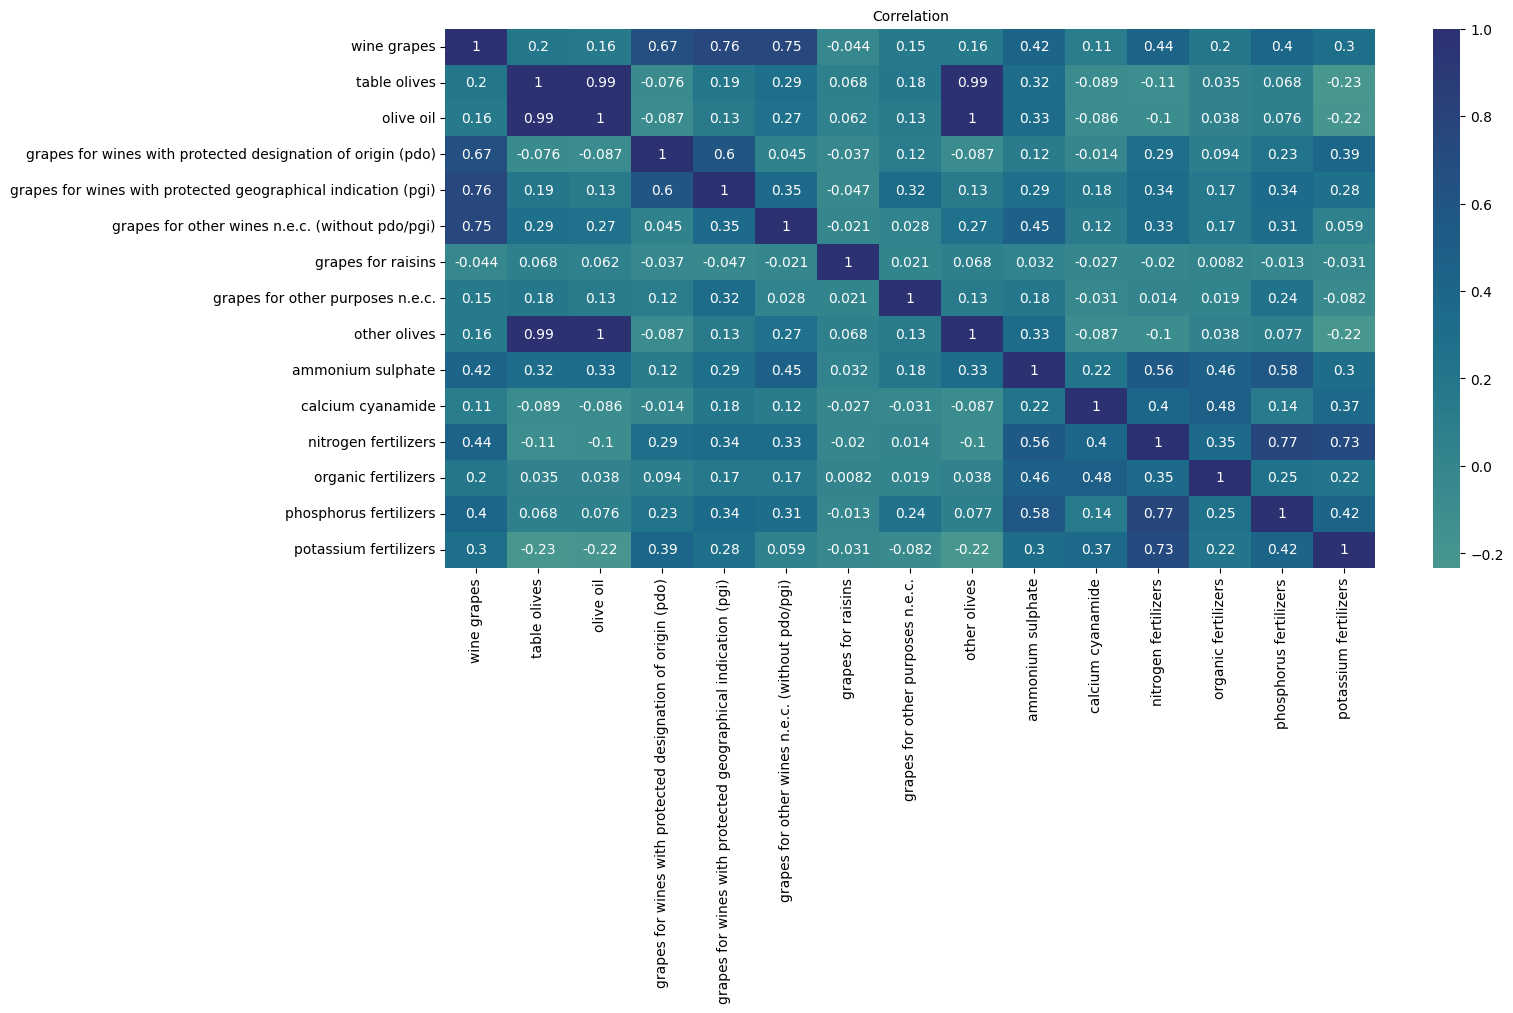

In [64]:
plt.figure(figsize=(15,7))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of grapes and olives production in Italy  2020: 

* Wine grapes has correlation nitrogen, phosphorus and ammonium sulphate fertilizers.

* Table olive has correlation with ammonium sulphate fertilizer.

* Olive oil ammonium sulphate fertilizer.

* Grapes for wine has correlation with potassium, phosphorus and nitrogen fertilizers.

* There is no high correlation between Grapes for raisins and other purposes, and fertilizers.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


### Correlation 2021


In [65]:

crop = it_crop_ferlizer2021.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer2021[['City','wine grapes', 'table olives','olive oil',
                                 'grapes for wines with protected designation of origin (pdo)',
                                 'grapes for wines with protected geographical indication (pgi)',
                                 'grapes for other wines n.e.c. (without pdo/pgi)','grapes for raisins',
                                 'grapes for other purposes n.e.c.', 'other olives','ammonium sulphate',
                                 'calcium cyanamide','nitrogen fertilizers', 'organic fertilizers',
                                 'phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

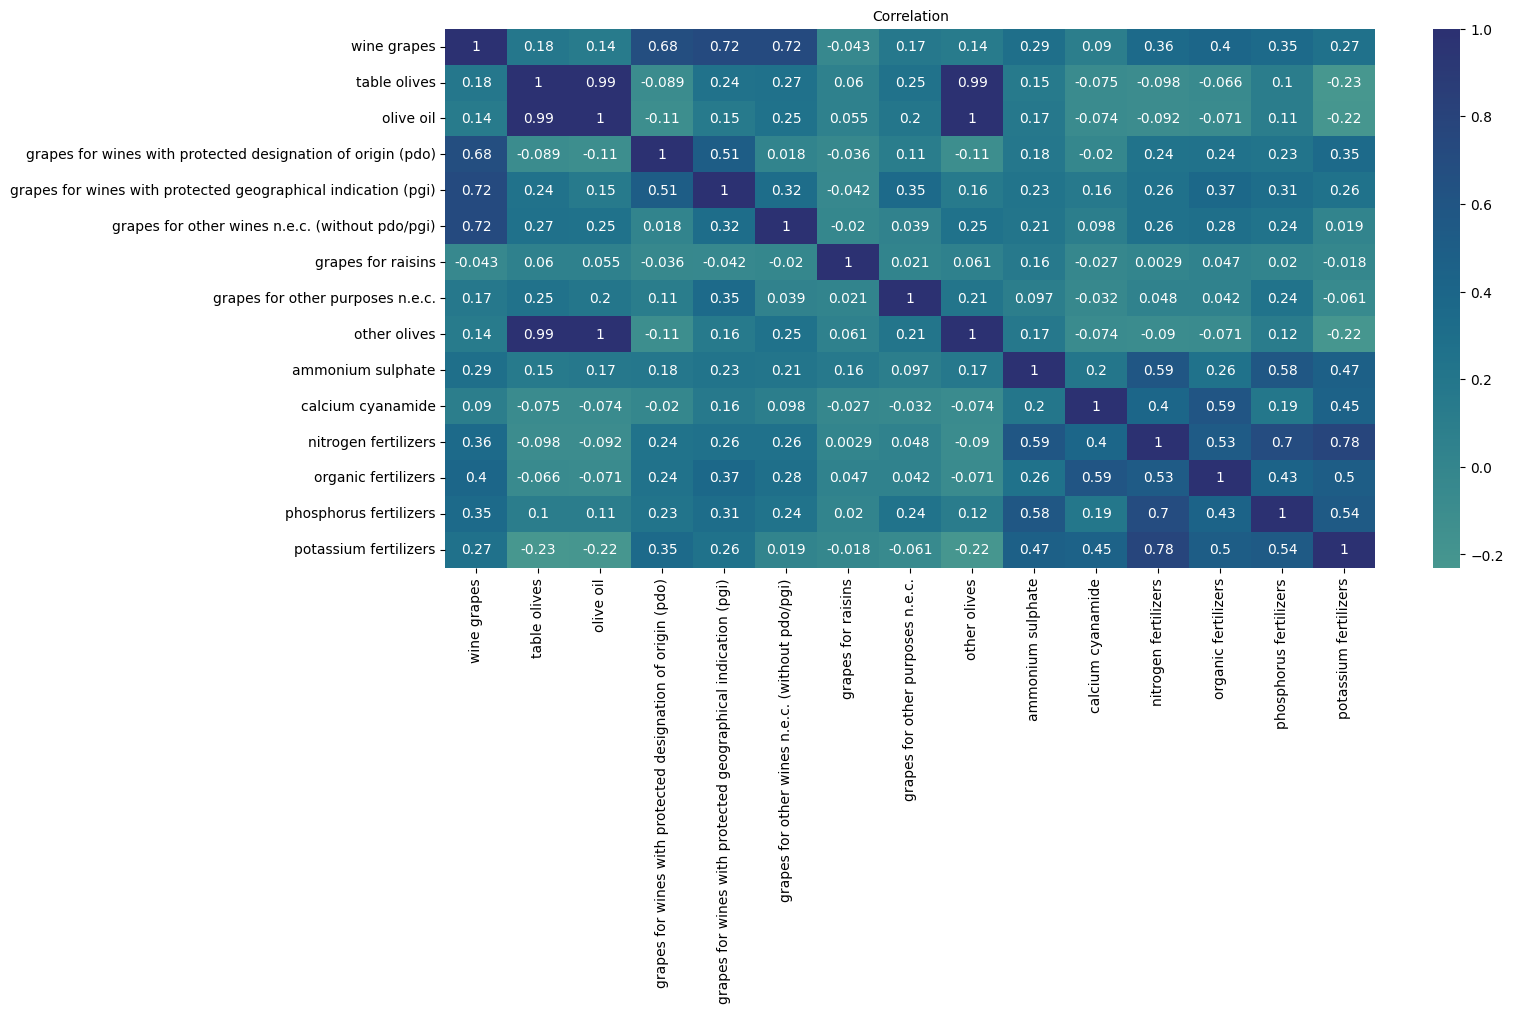

In [66]:
plt.figure(figsize=(15,7))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of grapes and olives production in Italy  2021: 

* Wine grapes has correlation organic, nitrogen, and phosphorus fertilizers.

* Table olive has low correlation with ammonium sulphate fertilizer, and negative correlation with calcium,potassium, organic, and nitrogen.

* Olive oil has low correlation with ammonium sulphate and phosphorus fertilizers.

* Grapes for wine has correlation with potassium, organic, phosphorus and nitrogen fertilizers.

* Grapes for raisins and other purposes has low correlation with fertilizers.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html